In [16]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [17]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 8.72 s, sys: 1.85 s, total: 10.6 s
Wall time: 10.6 s


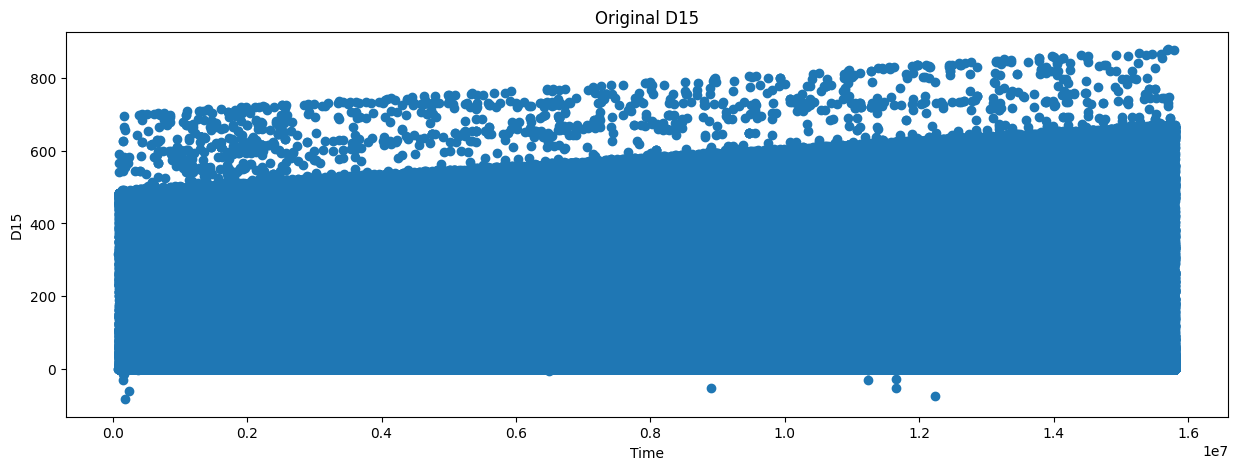

In [18]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

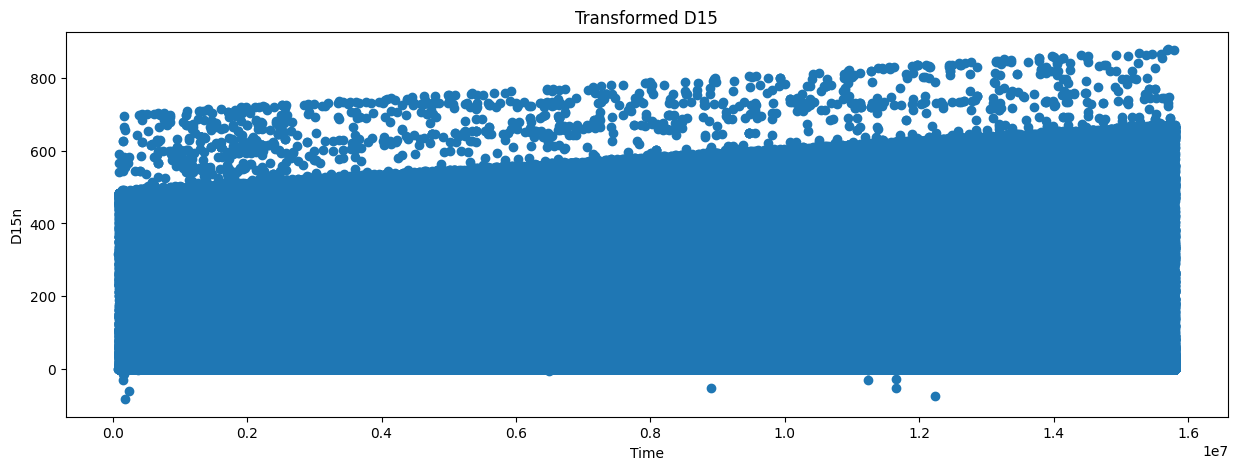

In [19]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [20]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if X_train[f].dtype == 'object': 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb, _ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000: 
            print(f, 'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # Convert Categorical to Ordered Categorical
    elif isinstance(X_train[f].dtype, pd.CategoricalDtype):
        X_train[f] = X_train[f].astype('category').cat.as_ordered()
        X_test[f] = X_test[f].astype('category').cat.as_ordered()
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace=True)
        X_test[f].fillna(-1, inplace=True)


<timed exec>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, t

CPU times: user 670 ms, sys: 76.4 ms, total: 746 ms
Wall time: 746 ms


In [21]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [22]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , 

<timed exec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_2638/1299026.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
/tmp/ipykernel_2638/1299026.py:10: PerformanceWarning: DataFrame is highly

card1_addr1 , 

/tmp/ipykernel_2638/1299026.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
/tmp/ipykernel_2638/1299026.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 

/tmp/ipykernel_2638/1299026.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
/tmp/ipykernel_2638/1299026.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
/tmp/ipykernel_2638/1299026.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm

'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 

/tmp/ipykernel_2638/1299026.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_2638/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_2638/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will nev

'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 

/tmp/ipykernel_2638/1299026.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_2638/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_2638/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will nev

'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 

/tmp/ipykernel_2638/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_2638/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[new_col_name].fillna(-1,inplace=True)
/tmp/ipykernel_2638/1

'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 2.24 s, sys: 117 ms, total: 2.36 s
Wall time: 2.35 s


/tmp/ipykernel_2638/1299026.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
/tmp/ipykernel_2638/1299026.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[new_col_name].fillna(-1,inplace=True)
/tmp/ipykernel_2638/1

In [23]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [24]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [25]:
# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [26]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

print("XGBoost version:", xgb.__version__)

# Create a simple dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Create an XGBClassifier with GPU support
model = XGBClassifier(tree_method='hist', device='cuda')
model.fit(X, y)

print("Model training completed successfully!")


XGBoost version: 2.1.0
Model training completed successfully!


In [27]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

if BUILD95:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='hist',
        device='cuda',
        enable_categorical=True  # Enable categorical support
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
                eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
                verbose=50)


XGBoost version: 2.1.0
[0]	validation_0-auc:0.81659
[50]	validation_0-auc:0.88541
[100]	validation_0-auc:0.90129
[150]	validation_0-auc:0.91263
[200]	validation_0-auc:0.91961
[250]	validation_0-auc:0.92499
[300]	validation_0-auc:0.92781
[350]	validation_0-auc:0.92999
[400]	validation_0-auc:0.93112
[450]	validation_0-auc:0.93149
[500]	validation_0-auc:0.93159
[550]	validation_0-auc:0.93162
[600]	validation_0-auc:0.93140
[650]	validation_0-auc:0.93121
[700]	validation_0-auc:0.93103
[750]	validation_0-auc:0.93068
[800]	validation_0-auc:0.93039
[850]	validation_0-auc:0.92998
[900]	validation_0-auc:0.92980
[950]	validation_0-auc:0.92947
[1000]	validation_0-auc:0.92936
[1050]	validation_0-auc:0.92914
[1100]	validation_0-auc:0.92899
[1150]	validation_0-auc:0.92873
[1200]	validation_0-auc:0.92863
[1250]	validation_0-auc:0.92829
[1300]	validation_0-auc:0.92798
[1350]	validation_0-auc:0.92793
[1400]	validation_0-auc:0.92769
[1450]	validation_0-auc:0.92752
[1500]	validation_0-auc:0.92740
[1550]	v

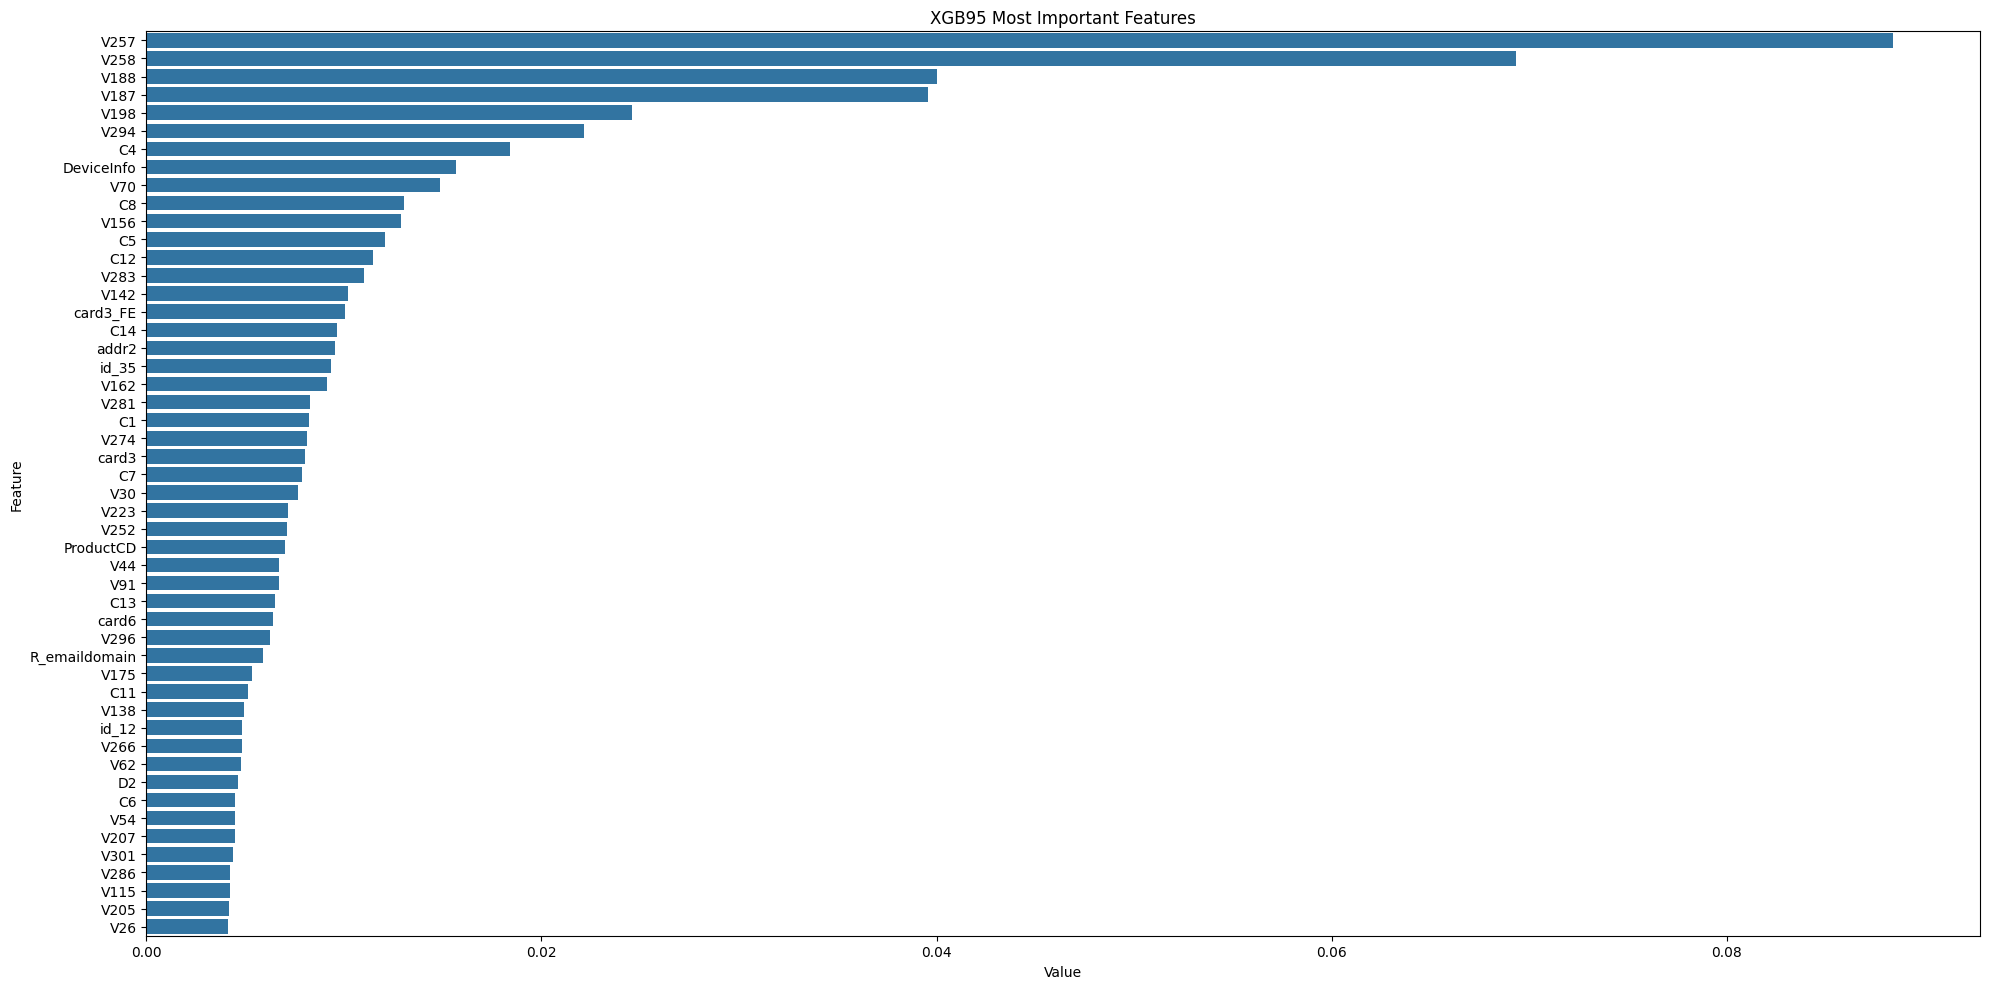

In [28]:
if BUILD95:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

In [29]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

/tmp/ipykernel_2638/3600872321.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
/tmp/ipykernel_2638/3600872321.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))


In [31]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import gc

if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold', i, 'withholding month', month)
        print(' rows of train =', len(idxT), 'rows of holdout =', len(idxV))
        
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            tree_method='hist',
            device='cuda',
            enable_categorical=True  # Enable categorical support
        )        
        clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV], y_train.iloc[idxV])],
                verbose=100)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:, 1]
        preds += clf.predict_proba(X_test[cols])[:, 1] / skf.n_splits
        del clf
        gc.collect()
        
    print('#'*20)
    print('XGB95 OOF CV =', roc_auc_score(y_train, oof))


Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.78305
[100]	validation_0-auc:0.88589
[200]	validation_0-auc:0.90430
[300]	validation_0-auc:0.91120
[400]	validation_0-auc:0.91565
[500]	validation_0-auc:0.91699
[600]	validation_0-auc:0.91701
[700]	validation_0-auc:0.91669
[800]	validation_0-auc:0.91543
[900]	validation_0-auc:0.91456
[1000]	validation_0-auc:0.91410
[1100]	validation_0-auc:0.91376
[1200]	validation_0-auc:0.91318
[1300]	validation_0-auc:0.91317
[1400]	validation_0-auc:0.91314
[1500]	validation_0-auc:0.91282
[1600]	validation_0-auc:0.91222
[1700]	validation_0-auc:0.91250
[1800]	validation_0-auc:0.91262
[1900]	validation_0-auc:0.91263
[2000]	validation_0-auc:0.91256
[2100]	validation_0-auc:0.91262
[2200]	validation_0-auc:0.91256
[2300]	validation_0-auc:0.91248
[2400]	validation_0-auc:0.91233
[2500]	validation_0-auc:0.91226
[2600]	validation_0-auc:0.91212
[2700]	validation_0-auc:0.91203
[2800]	validation_0-auc:0.91202
[2900]	

/home/codemaster29/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:09:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.83362
[100]	validation_0-auc:0.91413
[200]	validation_0-auc:0.93462
[300]	validation_0-auc:0.94155
[400]	validation_0-auc:0.94408
[500]	validation_0-auc:0.94505
[600]	validation_0-auc:0.94525
[700]	validation_0-auc:0.94524
[800]	validation_0-auc:0.94502
[900]	validation_0-auc:0.94498
[1000]	validation_0-auc:0.94462
[1100]	validation_0-auc:0.94456
[1200]	validation_0-auc:0.94429
[1300]	validation_0-auc:0.94394
[1400]	validation_0-auc:0.94372
[1500]	validation_0-auc:0.94350
[1600]	validation_0-auc:0.94329
[1700]	validation_0-auc:0.94319
[1800]	validation_0-auc:0.94308
[1900]	validation_0-auc:0.94312
[2000]	validation_0-auc:0.94294
[2100]	validation_0-auc:0.94293
[2200]	validation_0-auc:0.94286
[2300]	validation_0-auc:0.94283
[2400]	validation_0-auc:0.94272
[2500]	validation_0-auc:0.94261
[2600]	validation_0-auc:0.94251
[2700]	validation_0-auc:0.94256
[2800]	validation_0-auc:0.94249
[2900]	

In [33]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import gc

if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold', i, 'withholding month', month)
        print(' rows of train =', len(idxT), 'rows of holdout =', len(idxV))
        
        # Ensure categorical columns are properly encoded
        cat_cols = [col for col in X_train.columns if X_train[col].dtype.name == 'category']
        for col in cat_cols:
            X_train[col] = X_train[col].cat.codes.astype('int')
        
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            tree_method='hist',
            device='cuda',
            enable_categorical=True  # Enable categorical support
        )        
        clf.fit(X_train.iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train.iloc[idxV], y_train.iloc[idxV])],
                verbose=100)
    
        oof[idxV] += clf.predict_proba(X_train.iloc[idxV])[:, 1]
        preds += clf.predict_proba(X_test)[:, 1] / skf.n_splits
        del clf
        gc.collect()
        
    print('#' * 20)
    print('XGB95 OOF CV =', roc_auc_score(y_train, oof))


Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.76407
[100]	validation_0-auc:0.88289
[200]	validation_0-auc:0.90088
[300]	validation_0-auc:0.90678
[400]	validation_0-auc:0.90960
[500]	validation_0-auc:0.91069
[600]	validation_0-auc:0.91073
[700]	validation_0-auc:0.91003
[800]	validation_0-auc:0.90920
[900]	validation_0-auc:0.90881
[1000]	validation_0-auc:0.90848
[1100]	validation_0-auc:0.90807
[1200]	validation_0-auc:0.90765
[1300]	validation_0-auc:0.90719
[1400]	validation_0-auc:0.90766
[1500]	validation_0-auc:0.90757
[1600]	validation_0-auc:0.90750
[1700]	validation_0-auc:0.90762
[1800]	validation_0-auc:0.90785
[1900]	validation_0-auc:0.90820
[2000]	validation_0-auc:0.90837
[2100]	validation_0-auc:0.90818
[2200]	validation_0-auc:0.90792
[2300]	validation_0-auc:0.90827
[2400]	validation_0-auc:0.90819
[2500]	validation_0-auc:0.90824
[2600]	validation_0-auc:0.90834
[2700]	validation_0-auc:0.90823
[2800]	validation_0-auc:0.90822
[2900]	

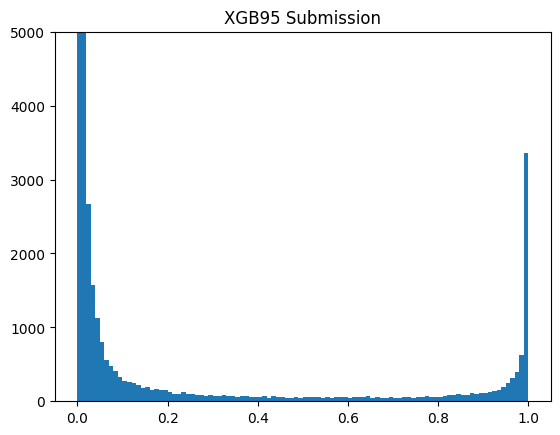

In [34]:
if BUILD95:
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_95.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB95 Submission')
    plt.show()

In [44]:
# Create new columns for X_train
X_train_new_columns = pd.DataFrame({
    'day': X_train.TransactionDT / (24*60*60),
    'uid': X_train.card1_addr1.astype(str) + '_' + np.floor(X_train.TransactionDT / (24*60*60) - X_train.D1).astype(str)
})

# Concatenate the new columns to X_train
X_train = pd.concat([X_train, X_train_new_columns], axis=1)

# Create new columns for X_test
X_test_new_columns = pd.DataFrame({
    'day': X_test.TransactionDT / (24*60*60),
    'uid': X_test.card1_addr1.astype(str) + '_' + np.floor(X_test.TransactionDT / (24*60*60) - X_test.D1).astype(str)
})

# Concatenate the new columns to X_test
X_test = pd.concat([X_test, X_test_new_columns], axis=1)


In [52]:
import numpy as np
import pandas as pd

# Define the encoding functions
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col], df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col + '_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].fillna(-1)
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].fillna(-1)

def encode_AG(main_cols, uids, aggregations, df1, df2, fillna=True, usena=True):
    for main_col in main_cols:
        for col in uids:
            for agg_type in aggregations:
                if df1[main_col].dtype.kind in 'biufc' and df2[main_col].dtype.kind in 'biufc':
                    new_col_name = f'{main_col}_{col}_{agg_type}'
                    temp_df = pd.concat([df1[[col, main_col]], df2[[col, main_col]]])
                    temp_df = temp_df.groupby([col])[main_col].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                    temp_df.index = list(temp_df[col])
                    temp_df = temp_df[new_col_name].to_dict()
                    df1[new_col_name] = df1[col].map(temp_df)
                    df2[new_col_name] = df2[col].map(temp_df)
                    if fillna:
                        df1[new_col_name] = df1[new_col_name].fillna(-1)
                        df2[new_col_name] = df2[new_col_name].fillna(-1)

def encode_AG2(main_cols, uids, train_df, test_df):
    for main_col in main_cols:
        for col in uids:
            if train_df[main_col].dtype.kind in 'biufc' and test_df[main_col].dtype.kind in 'biufc':
                temp_df = pd.concat([train_df[[col, main_col]], test_df[[col, main_col]]])
                temp_df = temp_df.groupby([col])[main_col].agg(['mean']).reset_index().rename(columns={'mean': main_col + '_mean_' + col})
                temp_df.index = list(temp_df[col])
                temp_df = temp_df.drop([col], axis=1)
                train_df = train_df.join(temp_df, on=col)
                test_df = test_df.join(temp_df, on=col)

# Remove duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Ensure all necessary columns are numeric before aggregation
numeric_columns = ['TransactionAmt', 'D4', 'D9', 'D10', 'D15', 'C14'] + ['C' + str(x) for x in range(1, 15) if x != 3] + ['M' + str(x) for x in range(1, 10)]
for col in numeric_columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Generate 'day' and 'uid' columns
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str) + '_' + np.floor(X_train.day - X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str) + '_' + np.floor(X_test.day - X_test.D1).astype(str)

# Ensure 'uid' is properly created
print(X_train['uid'].head())
print(X_test['uid'].head())

# FREQUENCY ENCODE UID
encode_FE(X_train, X_test, ['uid'])

# AGGREGATE 
encode_AG(['TransactionAmt', 'D4', 'D9', 'D10', 'D15'], ['uid'], ['mean', 'std'], X_train, X_test, fillna=True, usena=True)

# AGGREGATE
encode_AG(['C' + str(x) for x in range(1, 15) if x != 3], ['uid'], ['mean'], X_train, X_test, fillna=True, usena=True)

# AGGREGATE
encode_AG(['M' + str(x) for x in range(1, 10)], ['uid'], ['mean'], X_train, X_test, fillna=True, usena=True)

# AGGREGATE
encode_AG2(['P_emaildomain', 'dist1', 'DT_M', 'id_02', 'cents'], ['uid'], X_train, X_test)

# AGGREGATE
encode_AG(['C14'], ['uid'], ['std'], X_train, X_test, fillna=True, usena=True)

# AGGREGATE 
encode_AG2(['C13', 'V314'], ['uid'], X_train, X_test)

# AGGREGATE 
encode_AG2(['V127', 'V136', 'V309', 'V307', 'V320'], ['uid'], X_train, X_test)

# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1 - X_train.D15) > 3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1 - X_test.D15) > 3).astype('int8')

print('outsider15')


TransactionID
2987000.0     10230_-13.0
2987001.0       26060_1.0
2987002.0       32502_1.0
2987003.0    24904_-111.0
2987004.0       31942_1.0
Name: uid, dtype: object
TransactionID
3663549.0    53212_-206.0
3663550.0      31196_64.0
3663551.0      31898_76.0
3663552.0     55296_171.0
3663553.0     24437_191.0
Name: uid, dtype: object
outsider15


In [53]:
cols = list(X_train.columns)
cols.remove('TransactionDT')

# Remove specific columns
columns_to_remove = [
    'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 
    'oof', 'DT_M', 'day', 'uid',
    'C3', 'M5', 'id_08', 'id_33',
    'card4', 'id_07', 'id_14', 'id_21', 'id_30', 'id_32', 'id_34'
]
columns_to_remove += ['id_' + str(x) for x in range(22, 28)]

for col in columns_to_remove:
    if col in cols:
        cols.remove(col)


In [54]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 251 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [55]:
# TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [56]:
import xgboost as xgb

if BUILD96:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='hist',
        device='cuda'  
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50)

[0]	validation_0-auc:0.82569
[50]	validation_0-auc:0.89922
[100]	validation_0-auc:0.91633
[150]	validation_0-auc:0.92996
[200]	validation_0-auc:0.93717
[250]	validation_0-auc:0.94105
[300]	validation_0-auc:0.94316
[350]	validation_0-auc:0.94422
[400]	validation_0-auc:0.94463
[450]	validation_0-auc:0.94462
[500]	validation_0-auc:0.94460
[550]	validation_0-auc:0.94453
[600]	validation_0-auc:0.94444
[650]	validation_0-auc:0.94415
[700]	validation_0-auc:0.94381
[750]	validation_0-auc:0.94376
[800]	validation_0-auc:0.94357
[850]	validation_0-auc:0.94345
[900]	validation_0-auc:0.94332
[950]	validation_0-auc:0.94300
[1000]	validation_0-auc:0.94278
[1050]	validation_0-auc:0.94257
[1100]	validation_0-auc:0.94249
[1150]	validation_0-auc:0.94242
[1200]	validation_0-auc:0.94238
[1250]	validation_0-auc:0.94231
[1300]	validation_0-auc:0.94225
[1350]	validation_0-auc:0.94217
[1400]	validation_0-auc:0.94207
[1450]	validation_0-auc:0.94194
[1500]	validation_0-auc:0.94199
[1550]	validation_0-auc:0.94211

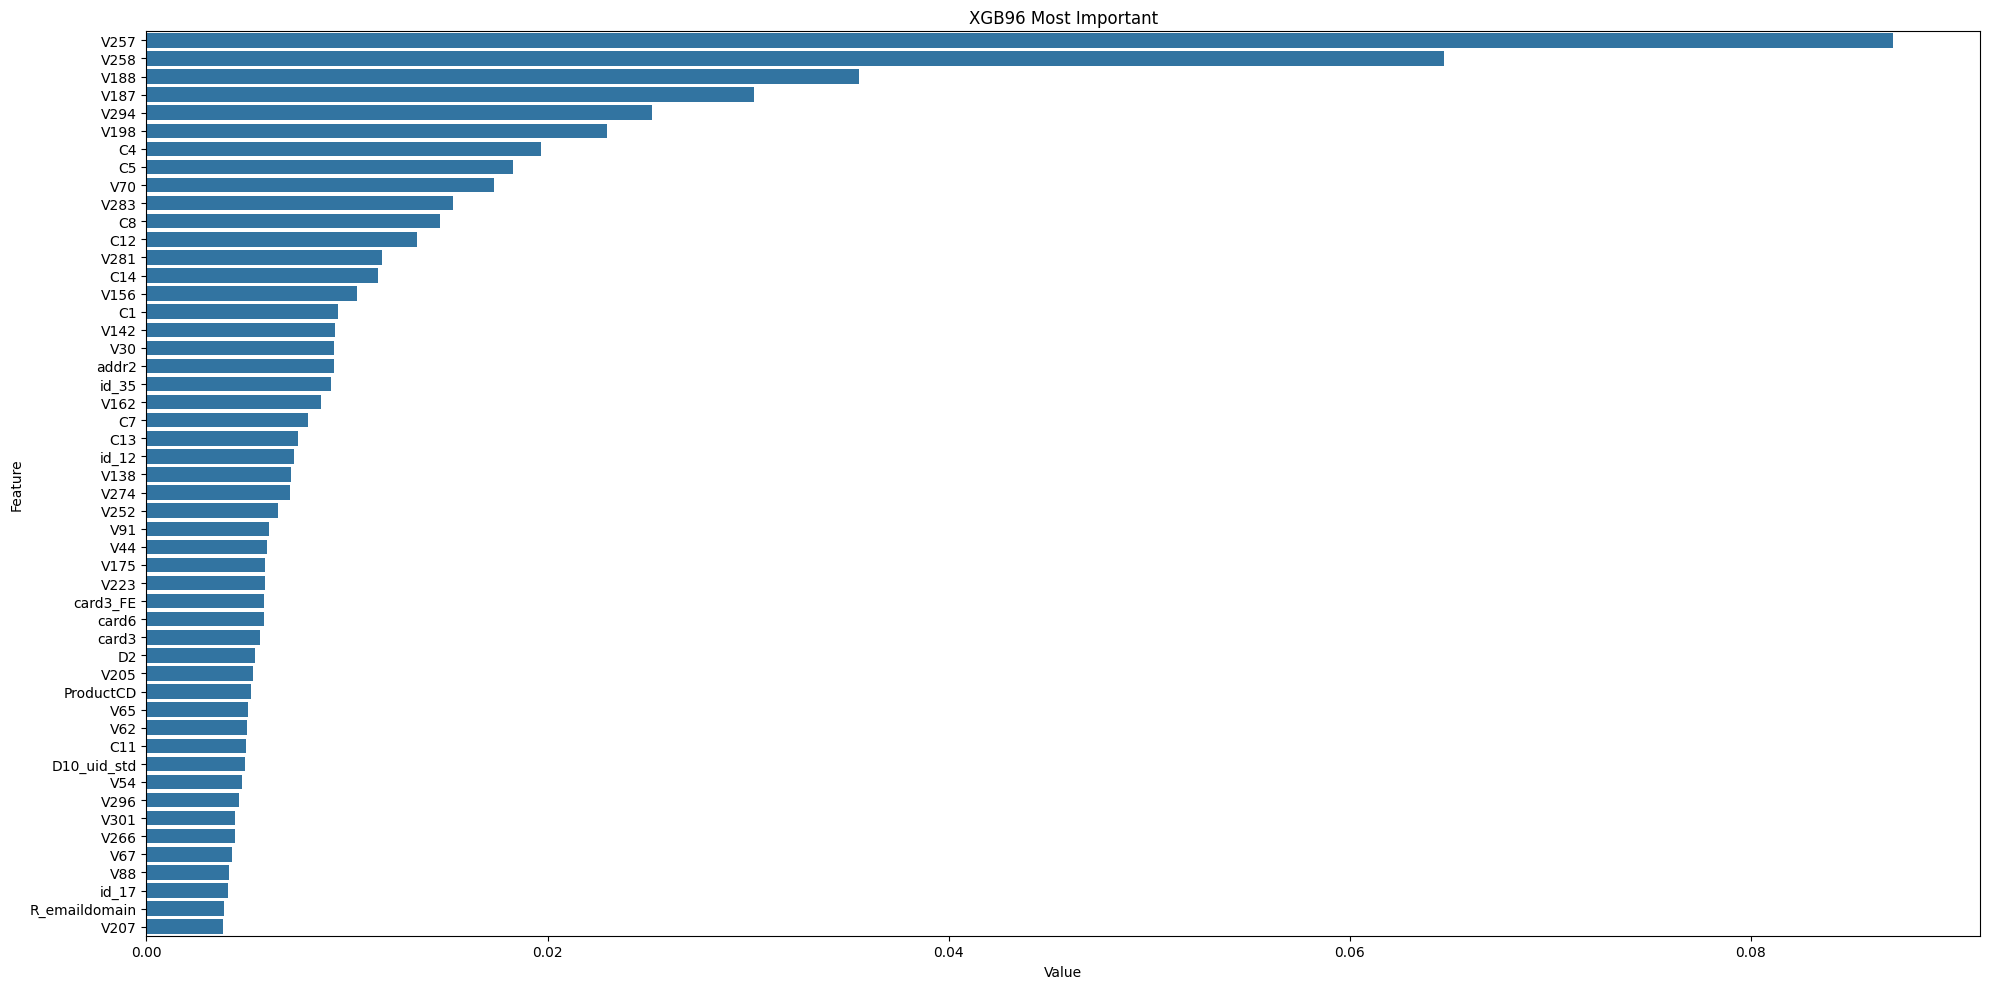

In [57]:
if BUILD96:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB96 Most Important')
    plt.tight_layout()
    plt.show()
        
    del clf, h; x=gc.collect()

In [58]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='hist',
            device='cuda' 
            
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.80088
[100]	validation_0-auc:0.90353
[200]	validation_0-auc:0.91886
[300]	validation_0-auc:0.92241
[400]	validation_0-auc:0.92365
[500]	validation_0-auc:0.92497
[600]	validation_0-auc:0.92533
[700]	validation_0-auc:0.92480
[800]	validation_0-auc:0.92492
[900]	validation_0-auc:0.92458
[1000]	validation_0-auc:0.92471
[1100]	validation_0-auc:0.92485
[1200]	validation_0-auc:0.92537
[1300]	validation_0-auc:0.92561
[1400]	validation_0-auc:0.92592
[1500]	validation_0-auc:0.92609
[1600]	validation_0-auc:0.92629
[1700]	validation_0-auc:0.92637
[1800]	validation_0-auc:0.92655
[1900]	validation_0-auc:0.92708
[2000]	validation_0-auc:0.92702
[2100]	validation_0-auc:0.92730
[2200]	validation_0-auc:0.92745
[2300]	validation_0-auc:0.92752
[2400]	validation_0-auc:0.92766
[2500]	validation_0-auc:0.92772
[2600]	validation_0-auc:0.92780
[2700]	validation_0-auc:0.92781
[2800]	validation_0-auc:0.92787
[2900]	

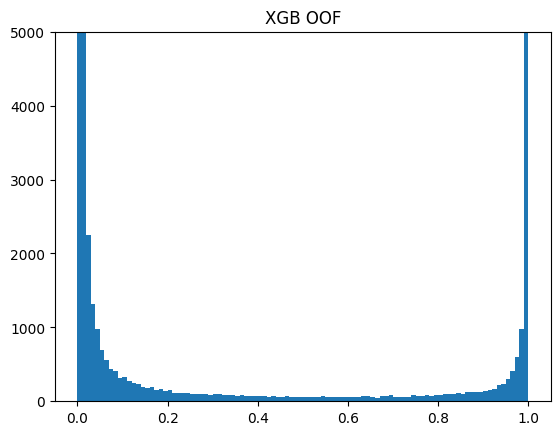

In [59]:
if BUILD96:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)

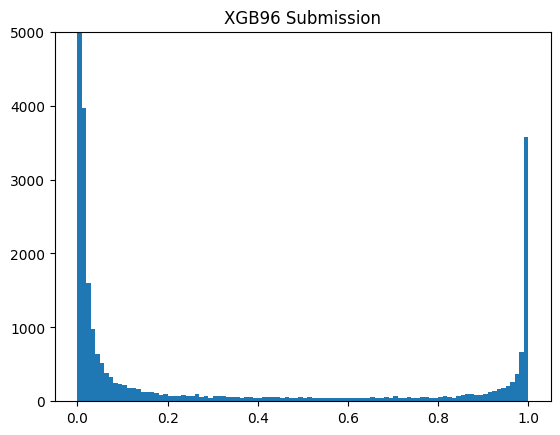

In [60]:
if BUILD96:
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_96.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB96 Submission')
    plt.show()

In [62]:
X_test['isFraud'] = sample_submission.isFraud.values
X_train['isFraud'] = y_train.values
comb = pd.concat([X_train[['isFraud']],X_test[['isFraud']]],axis=0)

uids = pd.read_csv('uids_v4_no_multiuid_cleaning.csv',usecols=['TransactionID','uid']).rename({'uid':'uid2'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid2').isFraud.agg(['mean'])
comb.loc[comb.uid2>0,'isFraud'] = comb.loc[comb.uid2>0].uid2.map(mp['mean'])

uids = pd.read_csv('uids_v1_no_multiuid_cleaning.csv',usecols=['TransactionID','uid']).rename({'uid':'uid3'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid3').isFraud.agg(['mean'])
comb.loc[comb.uid3>0,'isFraud'] = comb.loc[comb.uid3>0].uid3.map(mp['mean'])

sample_submission.isFraud = comb.iloc[len(X_train):].isFraud.values
sample_submission.to_csv('sub_xgb_96_PP.csv',index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'uids_v4_no_multiuid_cleaning.csv'